In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/pyTracker/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/pyTracker/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:

import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import datatypes
from datatypes import *

reload(TF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/pyTracker/tracker/utilities.py'>

In [4]:
steel_height=0.03 #m
Box_IP_Depth=85.47#m   

### Counting the number of tracks from LHC vs cosmic vs Background ### 

In [5]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

98


In [6]:

all_hits = [] # List of lists: each sublist is an event
all_tracks = [] #List of lists: each sublist is an event
all_vertices = [] #List of lists: each sublist is an event
nLHC = 0
nLHC_cosmic = 0
nLHC_back = 0
ncosmic = 0
ncosmic_back = 0
nback = 0
nall = 0

for f in pathList: # Go through each file
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)): # For each event
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        all_hits.append(hits)
        all_tracks.append(tracks)
        all_vertices.append(vertices)
        if len(tracks) == 0:
            continue
        for track in tracks: # For each track
            types = []
            hits_used = track.hits
            for hit in hits:
                if hit.ind in hits_used and hit.type not in types:
                    types.append(hit.type)
            if 0 in types and 1 in types and 2 in types:
                nall += 1
            elif 0 in types and 1 in types:
                nLHC_cosmic += 1
            elif 0 in types and 2 in types:
                nLHC_back +=1
            elif 1 in types and 2 in types:
                ncosmic_back += 1
            elif 0 in types:
                nLHC +=1
            elif 1 in types:
                ncosmic += 1
            elif 2 in types:
                nback += 1
            
print("Number of LHC only tracks:", nLHC)
print("Number of cosmic only tracks:", ncosmic)
print("Number of noise only tracks:", nback)
print("Number of LHC and cosmic tracks:", nLHC_cosmic)
print("Number of LHC and noise tracks:", nLHC_back)
print("Number of cosmic and noise tracks:", ncosmic_back)
print("Number of LHC, cosmic, and noise tracks:", nall)
        

Number of LHC only tracks: 12878
Number of cosmic only tracks: 7798
Number of noise only tracks: 1
Number of LHC and cosmic tracks: 3
Number of LHC and noise tracks: 100
Number of cosmic and noise tracks: 124
Number of LHC, cosmic, and noise tracks: 56


In [7]:
evNum = 0
for i in range(len(all_hits)):
    if len(all_vertices[i]) >0:
        evNum = i
        break

print(all_hits[evNum])
print("\n")
print(all_tracks[evNum])
print(all_vertices[evNum])


[Hit(x=-1232.0074815096812, y=8550.8, z=7452.25, t=381.0952983126022, x_err=13.416679869108547, y_err=0.2886751345948129, z_err=1.0103629710818451, t_err=0.7071067811865475, layer=2, ind=0, det_id=90102, type=0), Hit(x=-1248.9316196168809, y=8550.8, z=7456.75, t=379.65324840079325, x_err=13.416679869108547, y_err=0.2886751345948129, z_err=1.0103629710818451, t_err=0.7071067811865475, layer=2, ind=1, det_id=91002, type=0), Hit(x=-1245.75, y=8632.4, z=7507.4578032854815, t=384.07996792667365, x_err=1.0103629710818451, y_err=0.2886751345948129, z_err=13.416679869108547, t_err=0.7071067811865475, layer=3, ind=2, det_id=102303, type=0), Hit(x=-1254.75, y=8632.4, z=7524.690066455613, t=382.79721857002266, x_err=1.0103629710818451, y_err=0.2886751345948129, z_err=13.416679869108547, t_err=0.7071067811865475, layer=3, ind=7, det_id=102103, type=0), Hit(x=-134.25, y=9288.361542313825, z=6998.200000000001, t=85.58913711458445, x_err=1.0103629710818451, y_err=13.416679869108547, z_err=0.288675134

In [52]:
tracks = all_tracks[evNum]
hits = all_hits[evNum]
vertices = all_vertices[evNum]
for track in tracks:
    print(track.t0)
    # print(np.sqrt(np.diag(track.cov)))

440.52937470437456
440.75172282273587




4
5
6
7


4
5
6
7


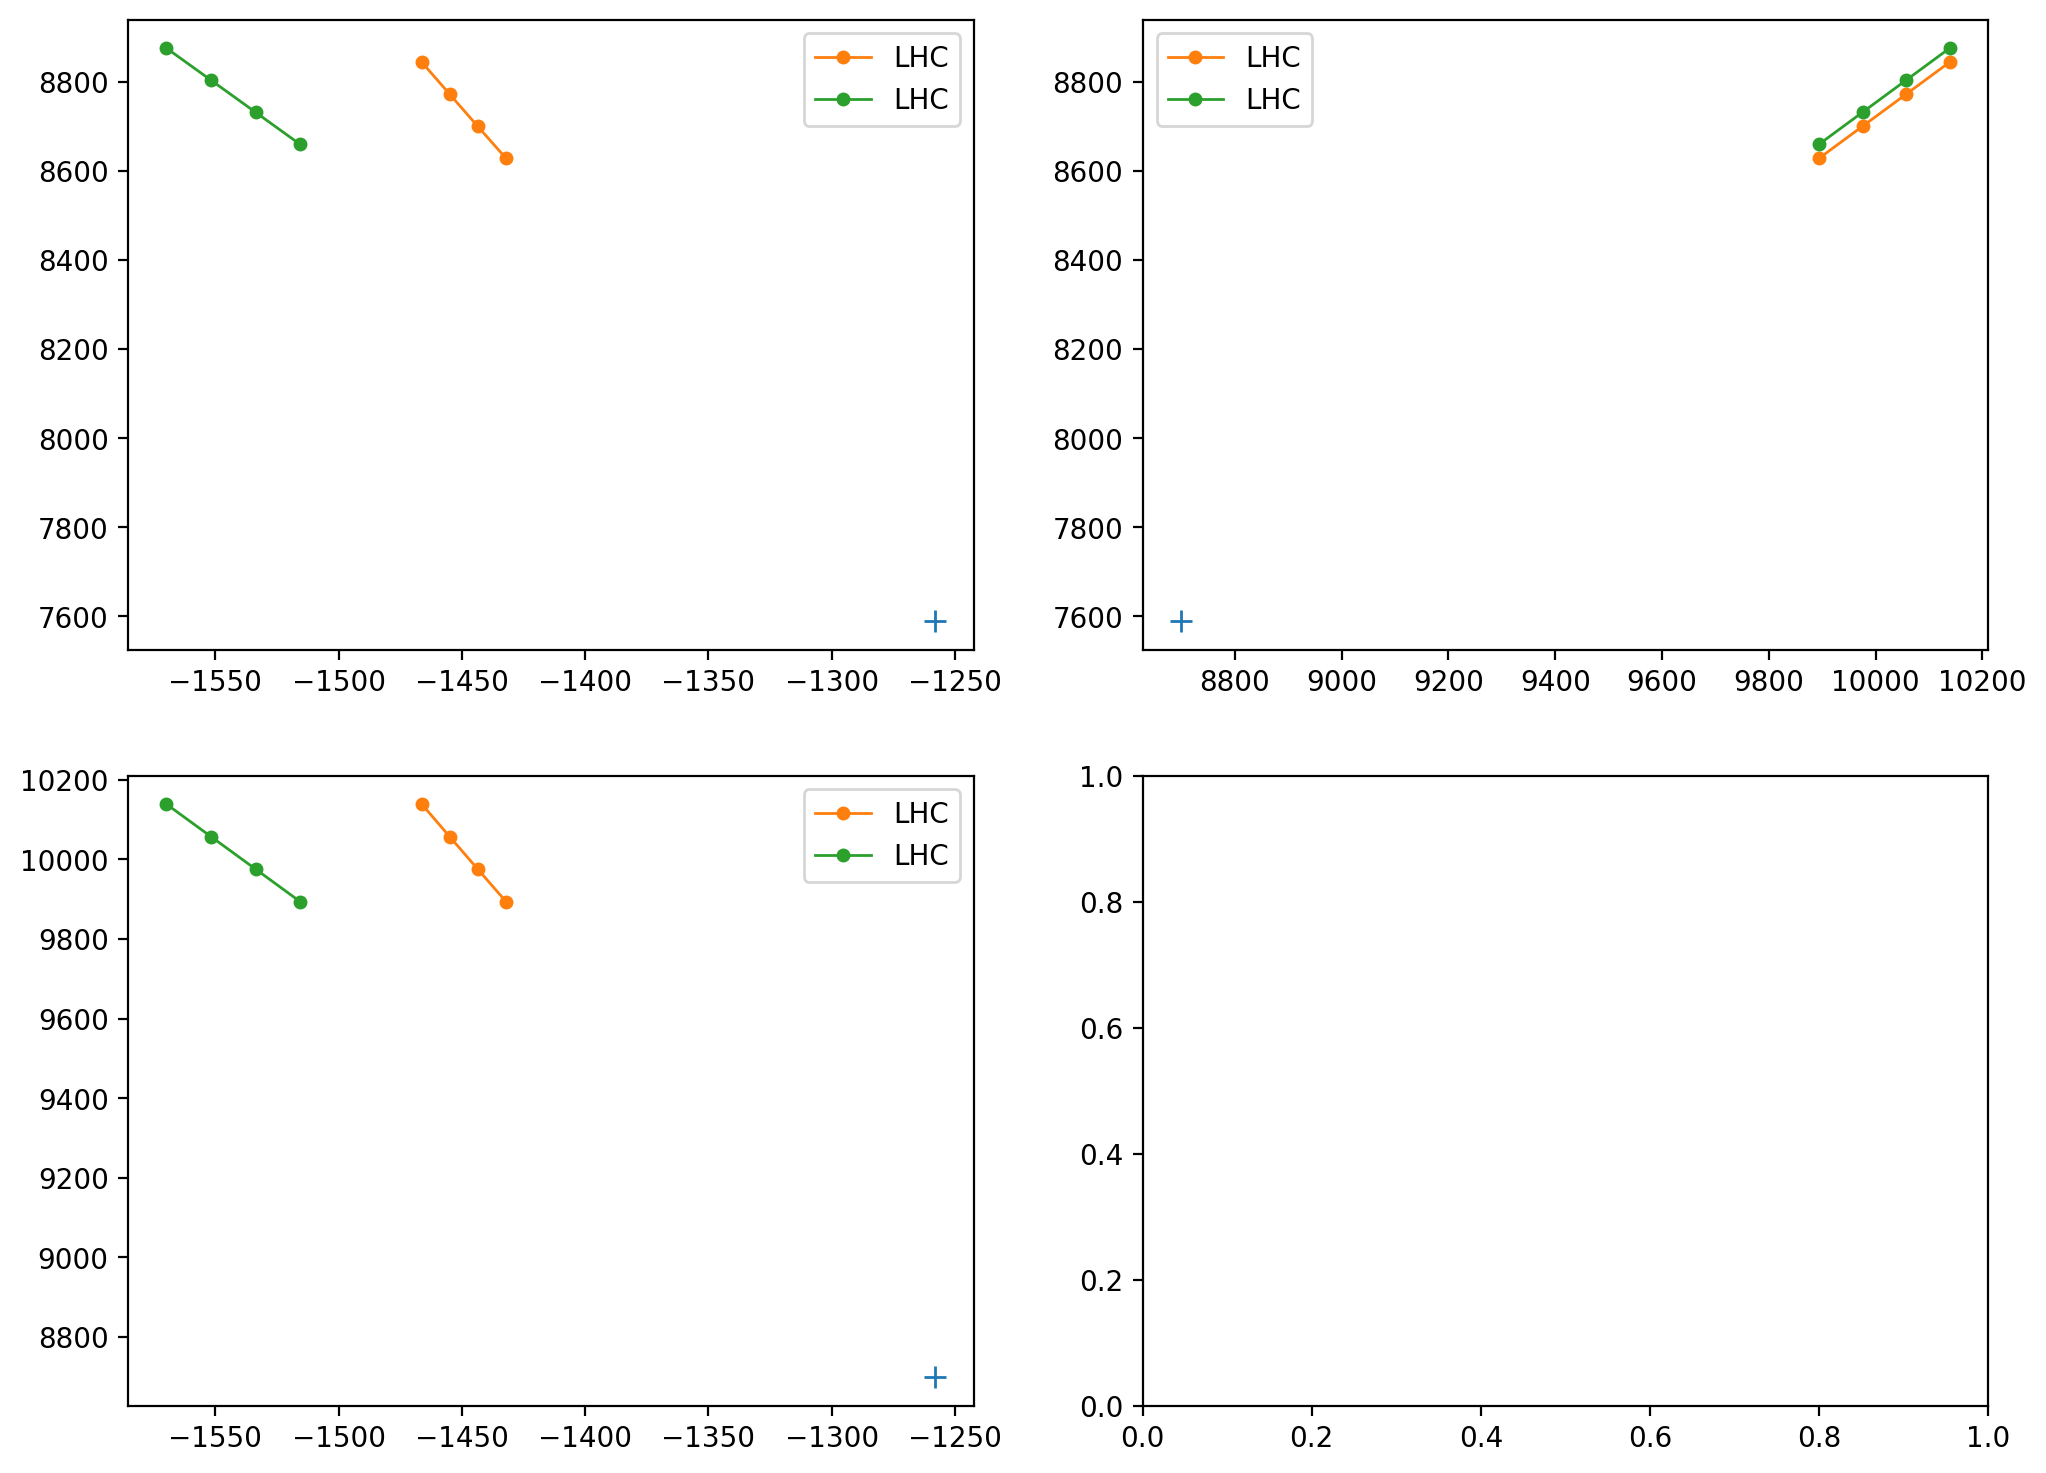

In [53]:
fig,axs=plt.subplots(2,2,figsize=(12,9))
axs=axs.flatten().tolist()

for vertex in vertices:
    vx = vertex.x0
    vy = vertex.y0
    vz = vertex.z0
    axs[0].plot(vx, vz, marker="+",markersize=8)
    axs[1].plot(vy, vz, marker="+", markersize=8)
    axs[2].plot(vx, vy, marker="+", markersize=8)
# Plot tracks
for track in tracks:
    # Each track is a list of each point is [x,y,z,t, PID, Energy, TRACK_ID]
    # x,y,z = coord_cms2det(np.array(track.hits_filtered).T)      
    x,y,z = np.array(track.hits_filtered).T[:3]
    print("\n")
    types = []
    hits_used = track.hits
    for hit in hits:
        if hit.ind in hits_used:
            print(hit.layer)
            if hit.type not in types:
                types.append(hit.type)
    if 0 in types and 1 in types and 2 in types:
        axs[0].plot(x, z,marker=".",linewidth=1,markersize=8,label="all")
        axs[1].plot(y, z,marker=".",linewidth=1,markersize=8,label="all")
        axs[2].plot(x, y,marker=".",linewidth=1,markersize=8,label="all")
    elif 0 in types and 1 in types:
        axs[0].plot(x, z,marker=".",linewidth=1,markersize=8,label="LHC + cosmic")
        axs[1].plot(y, z,marker=".",linewidth=1,markersize=8,label="LHC + cosmic")
        axs[2].plot(x, y,marker=".",linewidth=1,markersize=8,label="LHC + cosmic")
    elif 0 in types and 2 in types:
        axs[0].plot(x, z,marker=".",linewidth=1,markersize=8,label="LHC + noise")
        axs[1].plot(y, z,marker=".",linewidth=1,markersize=8,label="LHC + noise")
        axs[2].plot(x, y,marker=".",linewidth=1,markersize=8,label="LHC + noise")
    elif 1 in types and 2 in types:
        axs[0].plot(x, z,marker=".",linewidth=1,markersize=8,label="cosmic + noise")
        axs[1].plot(y, z,marker=".",linewidth=1,markersize=8,label="cosmic + noise")
        axs[2].plot(x, y,marker=".",linewidth=1,markersize=8,label="cosmic + noise")
    elif 0 in types:
        axs[0].plot(x, z,marker=".",linewidth=1,markersize=8,label="LHC")
        axs[1].plot(y, z,marker=".",linewidth=1,markersize=8,label="LHC")
        axs[2].plot(x, y,marker=".",linewidth=1,markersize=8,label="LHC")
    elif 1 in types:
        axs[0].plot(x, z,marker=".",linewidth=1,markersize=8,label="cosmic")
        axs[1].plot(y, z,marker=".",linewidth=1,markersize=8,label="cosmic")
        axs[2].plot(x, y,marker=".",linewidth=1,markersize=8,label="cosmic")
    elif 2 in types:
        axs[0].plot(x, z,marker=".",linewidth=1,markersize=8,label="noise")
        axs[1].plot(y, z,marker=".",linewidth=1,markersize=8,label="noise")
        axs[2].plot(x, y,marker=".",linewidth=1,markersize=8,label="noise")
    # axs[0].xlabel("x")
    # axs[0].ylabel("z")
    axs[0].legend()
    # axs[1].xlabel("y")
    # axs[1].ylabel("z")
    axs[1].legend()
    # axs[2].xlabel("y")
    # axs[2].ylabel("z")
    axs[2].legend()
    

In [35]:
for track in tracks:
    print(np.diag(track.cov), track.chi2)

[3.29688426e+00 1.01797418e+00 3.50109369e-01 1.95082237e-04
 1.16887786e-04 1.50840595e-05] 3.8975450795314432
[3.28528282e+00 1.01797207e+00 3.50061572e-01 1.93331113e-04
 1.18624866e-04 1.50649978e-05] 9.310225260045453
